In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [2]:
learning_rate=0.001
train_size=0.8
seqlen=1
bs=32
epochs=200

In [3]:
df=pd.read_csv('问题2-训练数据-归一化-回归.csv',index_col='time',parse_dates=True)
df

,100cm湿度(kg/m2),10cm湿度(kg/m2),200cm湿度(kg/m2),40cm湿度(kg/m2),month,year,土壤蒸发量(mm),平均气温(℃),降水量(mm)
time,,,,,,,,,
2012-01-01,0.008417,0.328250,1.000000,0.036261,1,0,0.008720,0.008070,0.002568
2012-02-01,0.008417,0.269663,1.000000,0.036261,2,0,0.015132,0.113180,0.002568
2012-03-01,0.008417,0.237560,1.000000,0.036261,3,0,0.042062,0.335609,0.024490
2012-04-01,0.007829,0.186998,1.000000,0.031885,4,0,0.177738,0.626319,0.006840
2012-05-01,0.004306,0.364366,1.000000,0.008753,5,0,0.457297,0.785020,0.056964
...,...,...,...,...,...,...,...,...,...
2021-11-01,0.999609,0.342697,0.002451,0.702094,11,9,0.030008,0.360852,0.595275
2021-12-01,1.000000,0.280899,0.000000,0.701157,12,9,0.016927,0.225947,0.217316
2022-01-01,1.000000,0.225522,0.000000,0.701157,1,10,0.004360,0.129112,0.681001


In [13]:
YCOLS=['100cm湿度(kg/m2)', '10cm湿度(kg/m2)', '200cm湿度(kg/m2)', '40cm湿度(kg/m2)',]
XCOLS=['month', 'year', '土壤蒸发量(mm)', '平均气温(℃)', '降水量(mm)']

X,Y=df[XCOLS].values,df[YCOLS].values

X_train,X_val,Y_train,Y_val = train_test_split(X,Y, train_size=train_size, shuffle=False)

In [14]:
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape

((98, 5), (25, 5), (98, 4), (25, 4))

In [12]:
inputs = keras.layers.Input(shape=(X_train.shape[1], ))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(Y_train.shape[1])(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 128)               768       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,796
Trainable params: 17,796
Non-trainable params: 0
_________________________________________________________________


In [119]:
path_checkpoint = "problem2_regress_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[es_callback, modelckpt_callback],
    batch_size=bs
)

Epoch 1/200
1/4 [======>.......................] - ETA: 5s - loss: 0.2287
Epoch 1: val_loss improved from inf to 0.29329, saving model to problem2_checkpoint.h5
4/4 [==============================] - 2s 144ms/step - loss: 0.1972 - val_loss: 0.2933
Epoch 2/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1701
Epoch 2: val_loss improved from 0.29329 to 0.28675, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 30ms/step - loss: 0.1900 - val_loss: 0.2868
Epoch 3/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1783
Epoch 3: val_loss improved from 0.28675 to 0.27978, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 44ms/step - loss: 0.1833 - val_loss: 0.2798
Epoch 4/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1752
Epoch 4: val_loss improved from 0.27978 to 0.27231, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 29ms/step - loss: 0.1764 - val_loss: 0.2723

Epoch 34/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0272
Epoch 34: val_loss did not improve from 0.13457
4/4 [==============================] - 0s 23ms/step - loss: 0.0291 - val_loss: 0.1377
Epoch 35/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0244
Epoch 35: val_loss did not improve from 0.13457
4/4 [==============================] - 0s 22ms/step - loss: 0.0281 - val_loss: 0.1376


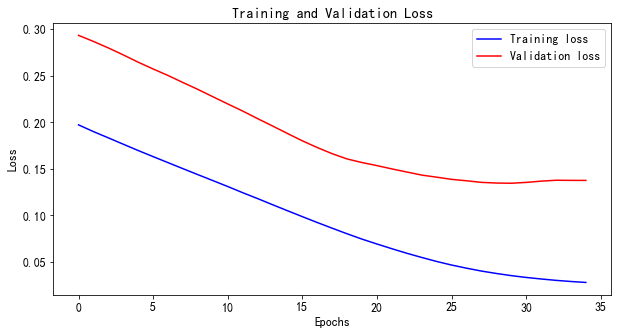

In [120]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")